In [1]:
import sys
sys.path.append('../code')
import torch as t 
import torch.nn.functional as F
import numpy as np
import tqdm
import matplotlib.pylab as plt
import matplotlib.cm as cm
import json
import hyperparams
from importlib import reload
from sklearn.decomposition import PCA

%matplotlib inline
plt.rcParams['figure.figsize']=(12,9)
plt.rcParams['font.size']= 20

In [86]:
start_num = 10 
total_iteration_num= 20000
exp_num = '2'

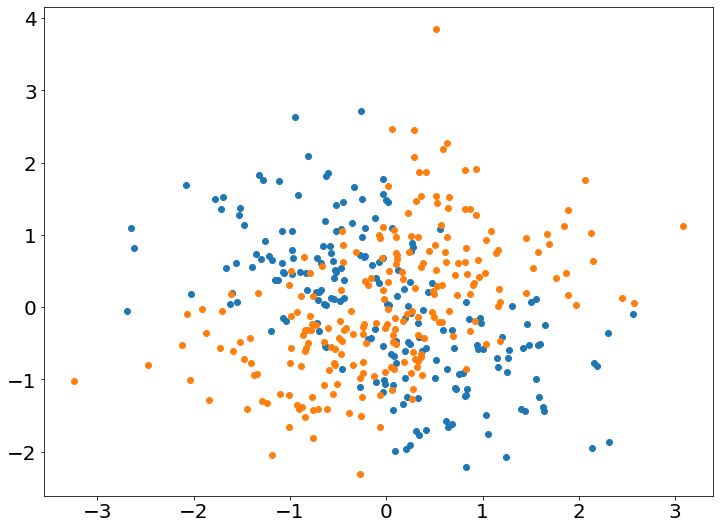

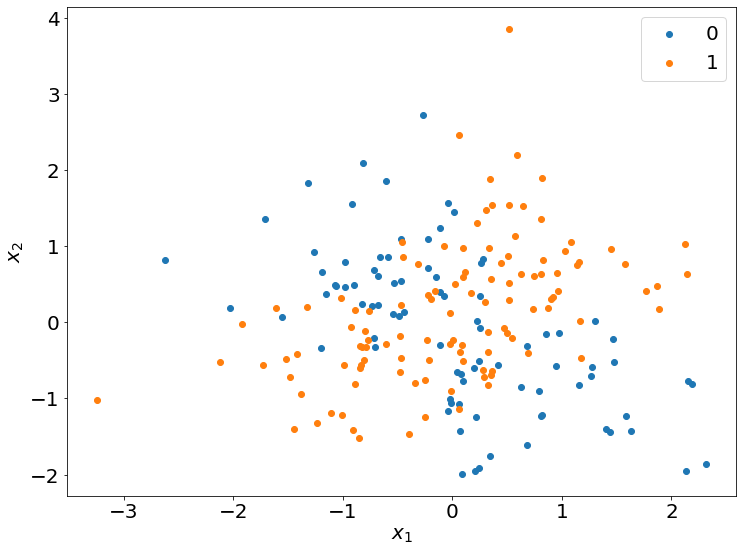

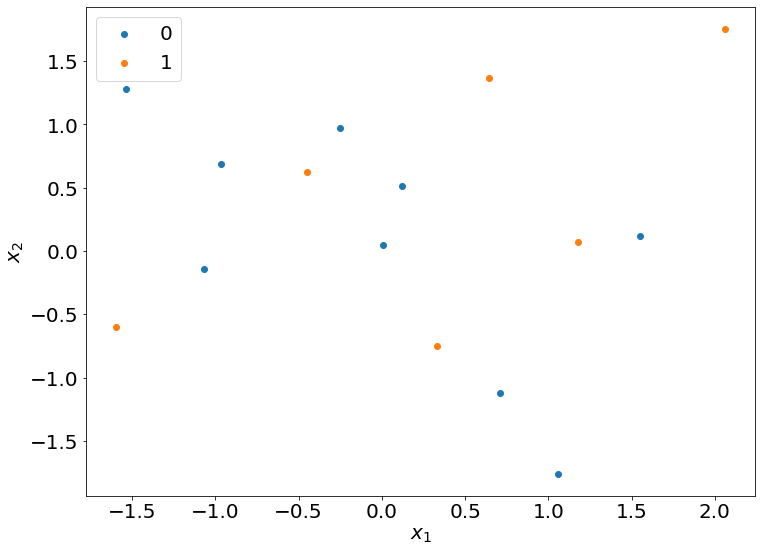

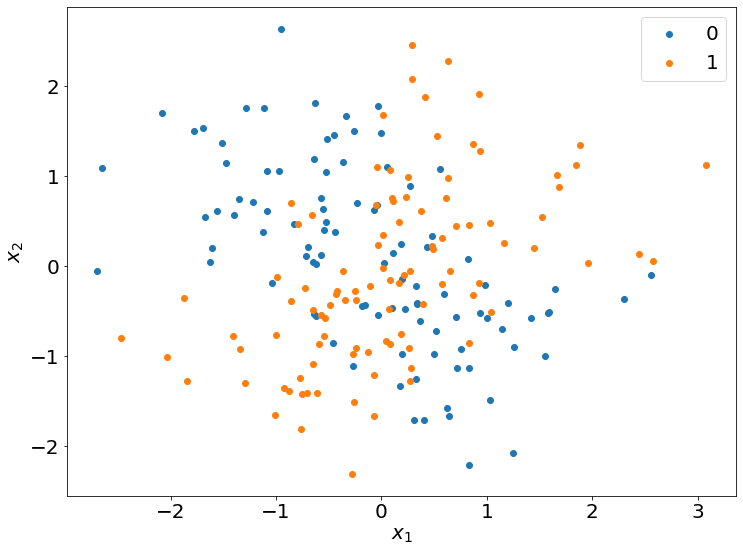

In [3]:
np.random.seed(42)
teacher_train_size, student_train_size, student_validation_size, test_size = 200, 15, 15, 200
total_size =  sum([teacher_train_size, student_train_size, student_validation_size, test_size])
eps = .5
"""
Y генерируется как:
    sign (x1 * x2) + шум
    
Признаки для учителя:
    x1; x2; индикатор, что x1 >0 и x2>0 
    Последний признак коррелирует с Y, но не покрывает его
    
Признаки для ученика:
    x1; x2; индикатор, что x1 >0 и x2>0 
    Последний признак отличается от Y из-за шума
        
    
"""
# полные данные
x_big = np.random.randn(total_size, 2)
y_big = (np.sign(x_big[:,0]*x_big[:,1]+np.random.randn(total_size)*eps)+1)//2
x_big = np.vstack([x_big[:,0], x_big[:,1],  (np.sign(x_big[:,0])+np.sign(x_big[:,1]) >0.1)*1.0, 
                   x_big[:,0]*x_big[:,1]]).T

# обучение учителя. NB: не пересекается с выборкой для обучения ученика, так проще подобрать параметры
x_ttrain = t.tensor(x_big[:teacher_train_size], dtype=t.float32)
y_ttrain = t.tensor(y_big[:teacher_train_size], dtype=t.long)


# обучение ученика
x_train = t.tensor(x_big[teacher_train_size:teacher_train_size+student_train_size], dtype=t.float32)
y_train = t.tensor(y_big[teacher_train_size:teacher_train_size+student_train_size], dtype=t.long)

# валидация, в этом ноутбуке не используется
x_val = t.tensor(x_big[teacher_train_size+student_train_size:teacher_train_size+student_train_size+student_validation_size], 
                 dtype=t.float32)
y_val = t.tensor(y_big[teacher_train_size+student_train_size:teacher_train_size+student_train_size+student_validation_size], dtype=t.long)


x_test = t.tensor(x_big[-test_size:], dtype=t.float32)
y_test = t.tensor(y_big[-test_size:], dtype=t.long)

plt.scatter(x_big[y_big==0,0], x_big[y_big==0,1])
plt.scatter(x_big[y_big==1,0], x_big[y_big==1,1])

plt.show()

plt.scatter(x_ttrain[y_ttrain==0,0], x_ttrain[y_ttrain==0,1], label='0')
plt.scatter(x_ttrain[y_ttrain==1,0], x_ttrain[y_ttrain==1,1], label='1')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.savefig('ttrain.pdf')
plt.legend()
plt.show()

plt.scatter(x_train[y_train==0,0], x_train[y_train==0,1], label='0')
plt.scatter(x_train[y_train==1,0], x_train[y_train==1,1], label='1')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.savefig('train.pdf')
plt.legend()
plt.show()

plt.scatter(x_test[y_test==0,0], x_test[y_test==0,1], label='0')
plt.scatter(x_test[y_test==1,0], x_test[y_test==1,1], label='1')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.savefig('test.pdf')
plt.legend()
plt.show()


In [4]:
class LogReg(t.nn.Module):
    def __init__(self, idx):
        t.nn.Module.__init__(self)
        self.lin = t.nn.Linear(len(idx), 2) 
        self.idx = idx        
    
    def forward(self, x):
        return self.lin(x[:, self.idx])
    
        

In [5]:
def accuracy(student, x,y):
    student.eval()
    total = 0 
    correct = 0
    with t.no_grad():
        out = student(x)
        correct += t.eq(t.argmax(out, 1), y).sum()
        total+=len(x)
    student.train()
    return (correct/total).cpu().detach().numpy()

In [6]:
# обучение учителя
t.manual_seed(0)
teacher = LogReg([0,1,2])
optim = t.optim.Adam(teacher.parameters())    
crit = t.nn.CrossEntropyLoss()
for e in range(10000):                                
    teacher.zero_grad() 
    loss = crit(teacher(x_ttrain), y_ttrain)
    loss.backward()
    optim.step()    
    
    teacher.eval()
    if e%1000==0:
        print (accuracy(teacher, x_test, y_test ))    
    teacher.train()
    



0.5
0.66
0.665
0.69
0.69
0.69
0.69
0.69
0.69
0.69


In [7]:
# обучение студента без дистилляции
student = LogReg([0,1,3])
optim = t.optim.Adam(student.parameters())    
crit = t.nn.CrossEntropyLoss()
for e in range(10000):                                
    student.zero_grad()            
    loss = crit(student(x_train), y_train)
    loss.backward()
    optim.step()        
    student.eval()
    if e%1000==0:
        print (accuracy(student, x_test, y_test ))    
    student.train()
    



0.48
0.69
0.725
0.745
0.76
0.755
0.755
0.755
0.755
0.755


In [8]:
kl = t.nn.KLDivLoss(reduction='batchmean')
sm = t.nn.Softmax(dim=1)

def distill(out, batch_logits, temp):
    g = sm(out/temp)
    f = t.nn.functional.log_softmax(batch_logits/temp)    
    return kl(f, g)

In [ ]:
# полная дистилляция
beta1 = 0.0
beta2 = 1.0
temp = 1.0
student = LogReg([0,1,3])
optim = t.optim.Adam(student.parameters())    
crit = t.nn.CrossEntropyLoss()
teacher.eval()
for e in range(10000):                                
    student.zero_grad()    
    out = student(x_train)
    student_loss = crit(out, y_train)            
    distillation_loss = distill(out, teacher(x_train), temp)
    loss = beta1 * student_loss + beta2*distillation_loss        
    loss.backward()
    optim.step()    
    
    student.eval()
    if e%1000==0:
        print (accuracy(student, x_test, y_test ))    
    student.train()
    

In [ ]:
# дистилляция с разными коэффициентами
beta1 = 1.0
beta2 = .5
temp = 1.0
student = LogReg([0,1,3])
optim = t.optim.Adam(student.parameters())    
crit = t.nn.CrossEntropyLoss()
teacher.eval()
for e in range(10000):                                
    student.zero_grad()    
    out = student(x_train)
    student_loss = crit(out, y_train)            
    distillation_loss = distill(out, teacher(x_train), temp)
    loss = beta1 * student_loss + beta2*distillation_loss        
    loss.backward()
    optim.step()    
    
    student.eval()
    if e%1000==0:
        print (accuracy(student, x_test, y_test ))    
    student.train()
    

In [9]:
# дистилляция с оптимизацией гиперапарметров

def param_loss(batch,model,h):
    x,y,batch_logits = batch    
    beta,beta2,temp = h
    out = model(x)
    beta = F.sigmoid(beta)
    beta2 = F.sigmoid(beta2)
    temp = F.sigmoid(temp) * 10
    distillation_loss = distill(out, batch_logits, temp)
    student_loss = crit(out, y)                
    loss = beta * distillation_loss + beta2 * student_loss
    return loss

def hyperparam_loss(batch, model):
    x,y = batch
    out = model(x)
    student_loss = crit(out, y)            
    return student_loss

for _ in range(start_num):
    results_opt = []

    beta1 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high = 1)), requires_grad=True)
    beta2 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high=1)), requires_grad=True)
    temp = t.nn.Parameter(t.tensor(np.random.uniform(low=-2, high=0)), requires_grad=True)
    h = [beta1, beta2, temp]

    student = LogReg([0,1,3])
    optim = t.optim.Adam(student.parameters())    
    optim2 = t.optim.Adam(h,  betas=(0.5, 0.999))   
    hyper_grad_calc = hyperparams.AdamHyperGradCalculator(student, param_loss, hyperparam_loss, optim, h)
    crit = t.nn.CrossEntropyLoss()
    teacher.eval()
    for e in range(total_iteration_num):
        
        optim2.zero_grad()            
        hyper_grad_calc.calc_gradients((x_train,y_train,teacher(x_train)), (x_test, y_test))
        optim2.step()

        optim.zero_grad()
        out = student(x_train)
        loss = param_loss((x_train,y_train,teacher(x_train)), student,h)
        loss.backward()
        optim.step()  
        student.train()       
        if e%1000==0:
            student.eval()
            print(accuracy(student, x_test, y_test), float(F.sigmoid(beta1).detach().numpy()), 
                  float(F.sigmoid(beta2).detach().numpy()), 
                  float(10*F.sigmoid(temp).detach().numpy()))
            student.train()
            results_opt.append([e, 
                                float(accuracy(student, x_test, y_test)),
                                float(F.sigmoid(beta1).detach().numpy()),
                                float(F.sigmoid(beta2).detach().numpy()), 
                                float(10*F.sigmoid(temp).detach().numpy())])
    with open('exp'+exp_num+'_linear_exp_hyper_opt.jsonl','a') as out:
        out.write(json.dumps(results_opt)+'\n')
    
            

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
<ipython-input-8-8c26b1136af2>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = t.nn.functional.log_softmax(batch_logits/temp)


0.66 0.5501200556755066 0.5080268979072571 4.598002731800079
0.75 0.5164719820022583 0.5747858881950378 5.006224513053894
0.755 0.510917603969574 0.5810941457748413 4.6778371930122375


KeyboardInterrupt: 

In [92]:
# дистилляция со сплайнами
# параметр: сколько итераций длится одна эпоха. Обучаемся каждую вторую эпоху
#epoch_size = 10
#epoch_size = 100
#epoch_size = 1000
# epoch_size = 2000




def param_loss(batch,model,h):
    x,y,batch_logits = batch    
    beta,beta2,temp = h
    out = model(x)
    beta = F.sigmoid(beta)
    beta2 = F.sigmoid(beta2)
    temp = F.sigmoid(temp) * 10
    distillation_loss = distill(out, batch_logits, temp)
    student_loss = crit(out, y)                
    loss = beta * distillation_loss + beta2 * student_loss
    return loss

def hyperparam_loss(batch, model):
    x,y = batch
    out = model(x)
    student_loss = crit(out, y)            
    return student_loss

for epoch_size in [10, 100, 500, 1000, 2000]:
    # results_opt = []
    for _ in range(start_num):
        results_opt = []
        beta1 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high = 1)), requires_grad=True)
        beta2 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high=1)), requires_grad=True)
        temp = t.nn.Parameter(t.tensor(np.random.uniform(low=-2, high=0)), requires_grad=True)
        h = [beta1, beta2, temp]

        student = LogReg([0,1,3])
        optim = t.optim.Adam(student.parameters())    
        optim2 = t.optim.Adam(h,  betas=(0.5, 0.999))   
        hyper_grad_calc = hyperparams.AdamHyperGradCalculator(student, param_loss, hyperparam_loss, optim, h)
        crit = t.nn.CrossEntropyLoss()
        teacher.eval()
        for e in range(total_iteration_num):
            e_ = e//epoch_size
            if e%epoch_size == 0 and e_ % 2 == 0:
                    spline_hist = []
                    spline_id  = -1 
                    #optim2 = t.optim.Adam(h,  betas=(0.5, 0.999))      
                    #hyper_grad_calc = hyperparams.AdamHyperGradCalculator(student, param_loss, hyperparam_loss, optim, h)
            spline_id+=1
            # если настала пора понаблюдать за траекторий гиперпараметров
            if  e_ % 2 == 0:           
                optim2.zero_grad()            
                hyper_grad_calc.calc_gradients((x_train,y_train,teacher(x_train)), (x_test, y_test))                        
                spline_hist.append([h_.grad.cpu().detach().clone().numpy() for h_ in h])
                optim2.step()                
            else:
                # иначе гиперпараметры предсказываем на основе сплайнов
                # здесь мы делаем костыль - не даем уйти гиперпараметрам в те значения,
                # в которых градиент потом будет нулевым            
                spline_out = splines(spline_id)
                optim2.zero_grad()            
                beta1.grad.data += spline_out[0]
                beta2.grad.data += spline_out[1]
                temp.grad.data += spline_out[2]
                optim2.step() 



            optim.zero_grad()
            out = student(x_train)
            loss = param_loss((x_train,y_train,teacher(x_train)), student,h)
            loss.backward()
            optim.step()  
            student.train()       
            if e%1000==0:
                student.eval()
                if e_ %2 == 0:
                    mode = 'hypertrain'
                else:
                    mode = 'hyperpredict'
                print(mode, accuracy(student, x_test, y_test), float(F.sigmoid(beta1).detach().numpy()), 
                      float(F.sigmoid(beta2).detach().numpy()), 
                      float(10*F.sigmoid(temp).detach().numpy()))
                student.train()

                results_opt.append([e, float(accuracy(student, x_test, y_test)), float(F.sigmoid(beta1).detach().numpy()),
                                    float(F.sigmoid(beta2).detach().numpy()), 
                                    float(10*F.sigmoid(temp).detach().numpy())])
            # если мы отслеживали траекторию эпохи - можно обучить на этом сплайны
            if e_ % 2 == 0 and e%epoch_size == epoch_size-1:
                    fitted1 = np.polyfit(range(len(spline_hist)), np.array(spline_hist)[:,0], 1)
                    fitted2 = np.polyfit(range(len(spline_hist)), np.array(spline_hist)[:,1], 1)
                    fitted3 = np.polyfit(range(len(spline_hist)), np.array(spline_hist)[:,2], 1)
                    splines = lambda x : np.array([np.polyval(fitted1, x), np.polyval(fitted2, x), np.polyval(fitted3, x)])

        with open('exp'+exp_num+'_linear_exp_splines_epoch_size_{}.jsonl'.format(epoch_size),'a') as out:
            out.write(json.dumps(results_opt)+'\n')

<ipython-input-8-8c26b1136af2>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = t.nn.functional.log_softmax(batch_logits/temp)


hypertrain 0.705 0.27875351905822754 0.296330988407135 3.449700176715851
hypertrain 0.76 0.2702986001968384 0.2817358672618866 3.0130529403686523
hypertrain 0.78 0.25722524523735046 0.2870257496833801 2.0598387718200684
hypertrain 0.81 0.19082672894001007 0.3641149401664734 1.0307808965444565
hypertrain 0.8 0.12690894305706024 0.4501960873603821 0.6006505712866783
hypertrain 0.78 0.11304203420877457 0.4683893024921417 0.34241408109664917
hypertrain 0.775 0.1479487419128418 0.39515233039855957 0.20415591076016426
hypertrain 0.785 0.0494215302169323 0.6412393450737 0.0758372014388442
hypertrain 0.8 0.03219383955001831 0.6973915696144104 0.03038411494344473
hypertrain 0.8 0.03045734204351902 0.7039752006530762 0.027722453232854605
hypertrain 0.8 0.029672501608729362 0.7068790197372437 0.0278595183044672
hypertrain 0.8 0.029179289937019348 0.7086641192436218 0.029563759453594685
hypertrain 0.8 0.029557714238762856 0.7078101634979248 0.03456843551248312
hypertrain 0.795 0.03196827694773674 

hypertrain 0.825 0.12569886445999146 0.8930468559265137 0.46092864125967026
hypertrain 0.825 0.10871386528015137 0.8990757465362549 0.44672463089227676
hypertrain 0.79 0.08203866332769394 0.9071999788284302 0.5200781673192978
hypertrain 0.755 0.05007287114858627 0.9225614666938782 0.8154875040054321
hypertrain 0.805 0.09054763615131378 0.9059864282608032 0.4187247157096863
hypertrain 0.78 0.06743643432855606 0.9149467945098877 0.5539340525865555
hypertrain 0.765 0.0521450936794281 0.9228384494781494 0.7003310322761536
hypertrain 0.785 0.11957547813653946 0.892254114151001 0.27367550879716873
hypertrain 0.78 0.15814968943595886 0.8729295134544373 0.20536979660391808
hypertrain 0.6 0.38876479864120483 0.6449361443519592 1.6392116248607635
hypertrain 0.795 0.356589138507843 0.7417386770248413 0.8642753958702087
hypertrain 0.8 0.245978444814682 0.8043334484100342 0.5283521860837936
hypertrain 0.78 0.23813532292842865 0.8146831393241882 0.27640625834465027
hypertrain 0.795 0.179192319512367

In [52]:
#all_hist1 = all_hist.copy()

In [ ]:
F.sigmoid(t.tensor(0.0))*10

In [95]:
# дистилляция со сплайнами
# параметр: раз в сколько эпох мы обучаем сплайны

# train_splines_every_epoch = 2
# train_splines_every_epoch = 3
# train_splines_every_epoch = 5
#train_splines_every_epoch = 10
epoch_size = 10 # !!! размер эпохи нужно подобрать экспериментом выше


def param_loss(batch,model,h):
    x,y,batch_logits = batch    
    beta,beta2,temp = h
    out = model(x)
    beta = F.sigmoid(beta)
    beta2 = F.sigmoid(beta2)
    temp = F.sigmoid(temp) * 10
    distillation_loss = distill(out, batch_logits, temp)
    student_loss = crit(out, y)                
    loss = beta * distillation_loss + beta2 * student_loss
    return loss

def hyperparam_loss(batch, model):
    x,y = batch
    out = model(x)
    student_loss = crit(out, y)            
    return student_loss

for train_splines_every_epoch in [2,3,5,10]:
    for _ in range(start_num):
        results_opt = []

        beta1 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high = 1)), requires_grad=True)
        beta2 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high=1)), requires_grad=True)
        temp = t.nn.Parameter(t.tensor(np.random.uniform(low=-2, high=0)), requires_grad=True)
        h = [beta1, beta2, temp]

        student = LogReg([0,1,3])
        optim = t.optim.Adam(student.parameters())    
        optim2 = t.optim.Adam(h,  betas=(0.5, 0.999))   
        hyper_grad_calc = hyperparams.AdamHyperGradCalculator(student, param_loss, hyperparam_loss, optim, h)
        crit = t.nn.CrossEntropyLoss()
        teacher.eval()
        for e in range(total_iteration_num):
            e_ = e//epoch_size

            if e%epoch_size == 0 and e_ % train_splines_every_epoch == 0:
                    spline_hist = []
                    spline_id  = -1                 
            spline_id+=1
            # если настала пора понаблюдать за траекторий гиперпараметров
            if e_ % train_splines_every_epoch == 0:           
                optim2.zero_grad()            
                hyper_grad_calc.calc_gradients((x_train,y_train,teacher(x_train)), (x_test, y_test))            
                optim2.step()                
                spline_hist.append([h_.grad.cpu().detach().clone().numpy() for h_ in h])

            else:
                # иначе гиперпараметры предсказываем на основе сплайнов
                # здесь мы делаем костыль - не даем уйти гиперпараметрам в те значения,
                # в которых градиент потом будет нулевым                
                spline_out = splines(spline_id)
                optim2.zero_grad()            
                beta1.grad.data += spline_out[0]
                beta2.grad.data += spline_out[1]
                temp.grad.data += spline_out[2]
                optim2.step() 



            optim.zero_grad()
            out = student(x_train)
            loss = param_loss((x_train,y_train,teacher(x_train)), student,h)
            loss.backward()
            optim.step()  
            student.train()       
            if e%1000==0:
                student.eval()
                if e_ % train_splines_every_epoch == 0:
                    mode = 'hypertrain'
                else:
                    mode = 'hyperpredict'
                print(mode, accuracy(student, x_test, y_test), float(F.sigmoid(beta1).detach().numpy()), 
                      float(F.sigmoid(beta2).detach().numpy()), 
                      float(10*F.sigmoid(temp).detach().numpy()))
                student.train()

                results_opt.append([e, float(accuracy(student, x_test, y_test)), float(F.sigmoid(beta1).detach().numpy()),
                                    float(F.sigmoid(beta2).detach().numpy()), 
                                    float(10*F.sigmoid(temp).detach().numpy())])

            # если мы отслеживали траекторию эпохи - можно обучить на этом сплайны
            if e_ % train_splines_every_epoch == 0 and e%epoch_size == epoch_size-1:
                    fitted1 = np.polyfit(range(len(spline_hist)), np.array(spline_hist)[:,0], 1)
                    fitted2 = np.polyfit(range(len(spline_hist)), np.array(spline_hist)[:,1], 1)
                    fitted3 = np.polyfit(range(len(spline_hist)), np.array(spline_hist)[:,2], 1)
                    splines = lambda x : np.array([np.polyval(fitted1, x), np.polyval(fitted2, x), np.polyval(fitted2, x)])
        with open('exp'+exp_num+'_linear_exp_splines_train_every_{}.jsonl'.format(train_splines_every_epoch),'a') as out:
            out.write(json.dumps(results_opt)+'\n')

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
<ipython-input-8-8c26b1136af2>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = t.nn.functional.log_softmax(batch_logits/temp)


hypertrain 0.295 0.3578363060951233 0.46260541677474976 2.223319560289383
hypertrain 0.685 0.3814907968044281 0.5862715840339661 2.677794098854065
hypertrain 0.74 0.38428521156311035 0.6541561484336853 2.816915214061737
hypertrain 0.755 0.41471460461616516 0.6663393974304199 2.1066762506961823
hypertrain 0.805 0.3839398920536041 0.6912381052970886 1.1848889291286469
hypertrain 0.825 0.2643010914325714 0.7604127526283264 0.8270455896854401
hypertrain 0.83 0.17405326664447784 0.801979660987854 0.6019733101129532
hypertrain 0.83 0.12267794460058212 0.8239225745201111 0.4725472256541252
hypertrain 0.825 0.09747423976659775 0.8343709707260132 0.4053318127989769
hypertrain 0.825 0.08647150546312332 0.8387865424156189 0.37484828382730484
hypertrain 0.825 0.08238522708415985 0.8403645753860474 0.36327239125967026
hypertrain 0.825 0.08107262849807739 0.8408509492874146 0.35952553153038025
hypertrain 0.825 0.08070085942745209 0.8409796357154846 0.3584779426455498
hypertrain 0.825 0.0806156322360

hypertrain 0.77 0.4409038722515106 0.5511066913604736 3.3142825961112976
hypertrain 0.76 0.44406479597091675 0.5481481552124023 2.5679096579551697
hypertrain 0.8 0.42113444209098816 0.565777599811554 1.5988464653491974
hypertrain 0.815 0.3066701889038086 0.6469043493270874 1.0324864834547043
hypertrain 0.83 0.2045249044895172 0.710722029209137 0.7223707437515259
hypertrain 0.83 0.1394125521183014 0.7510501146316528 0.5435755848884583
hypertrain 0.825 0.10405909270048141 0.7737360000610352 0.4429714009165764
hypertrain 0.825 0.08697667717933655 0.7848705053329468 0.3921767696738243
hypertrain 0.825 0.07975655049085617 0.7894678711891174 0.37013646215200424
hypertrain 0.405 0.6296578645706177 0.6220034956932068 4.519479274749756
hypertrain 0.71 0.6364995241165161 0.71826171875 5.144115686416626
hypertrain 0.74 0.633042573928833 0.7563009858131409 5.408430099487305
hypertrain 0.75 0.6279277205467224 0.768388569355011 5.427269339561462
hypertrain 0.76 0.6238721013069153 0.7716038227081299 

hyperpredict 0.745 0.5318025946617126 0.48223695158958435 3.8577279448509216
hypertrain 0.755 0.5170832872390747 0.5056402683258057 3.883129358291626
hyperpredict 0.77 0.5054357051849365 0.5157780051231384 3.722333610057831
hyperpredict 0.77 0.4950717091560364 0.523887038230896 3.4788498282432556
hypertrain 0.765 0.4856525659561157 0.5315804481506348 3.144088387489319
hyperpredict 0.76 0.4761155843734741 0.5395829677581787 2.6747652888298035
hyperpredict 0.775 0.45926180481910706 0.5528717041015625 2.0739734172821045
hypertrain 0.795 0.4060920476913452 0.5951562523841858 1.459316909313202
hyperpredict 0.815 0.312055379152298 0.6584387421607971 1.0508298128843307
hyperpredict 0.825 0.22434860467910767 0.7102813720703125 0.7812092453241348
hypertrain 0.83 0.15774109959602356 0.7494351863861084 0.5984266102313995
hyperpredict 0.825 0.11554671078920364 0.7759787440299988 0.4755939915776253
hyperpredict 0.825 0.09219657629728317 0.792097270488739 0.40614139288663864
hypertrain 0.825 0.08222

hypertrain 0.825 0.07853186875581741 0.7582710981369019 0.3767653927206993
hyperpredict 0.825 0.0749824121594429 0.7612745761871338 0.3644115850329399
hyperpredict 0.825 0.0736241340637207 0.7623474597930908 0.3599407523870468
hypertrain 0.825 0.07321567833423615 0.762664794921875 0.35858258605003357
hyperpredict 0.825 0.07312728464603424 0.7627386450767517 0.35826630890369415
hyperpredict 0.825 0.07312855124473572 0.7627455592155457 0.35827163606882095
hypertrain 0.825 0.07309455424547195 0.7627928256988525 0.35813726484775543
hyperpredict 0.825 0.07308043539524078 0.762820303440094 0.3581051528453827
hypertrain 0.6 0.33099573850631714 0.7239987254142761 2.6050743460655212
hyperpredict 0.73 0.3086259663105011 0.7948898673057556 3.2432422041893005
hyperpredict 0.75 0.32409098744392395 0.8082908987998962 3.152574598789215
hypertrain 0.76 0.3752681314945221 0.8037128448486328 2.5657474994659424
hyperpredict 0.785 0.48884332180023193 0.7730510234832764 1.5064060688018799
hyperpredict 0.81

hypertrain 0.765 0.6918997168540955 0.7647411823272705 2.7168962359428406
hypertrain 0.76 0.6815325617790222 0.7743544578552246 2.3627054691314697
hypertrain 0.785 0.6597906947135925 0.7861995697021484 1.8808111548423767
hypertrain 0.8 0.5937092900276184 0.8159120678901672 1.4868775010108948
hypertrain 0.815 0.48430779576301575 0.8468328714370728 1.1999213695526123
hypertrain 0.815 0.3693423569202423 0.8683176040649414 0.9627103060483932
hypertrain 0.83 0.2695666253566742 0.8829546570777893 0.7631183415651321
hypertrain 0.83 0.19159887731075287 0.8931952714920044 0.6083108857274055
hypertrain 0.825 0.1323947012424469 0.9021698236465454 0.4811534285545349
hypertrain 0.825 0.09464827924966812 0.9090228080749512 0.3904580697417259
hypertrain 0.825 0.07700730860233307 0.9129078388214111 0.33575378358364105
hypertrain 0.81 0.0920044556260109 0.9094808101654053 0.3489164263010025
hypertrain 0.825 0.10070259869098663 0.9068507552146912 0.39831679314374924
hypertrain 0.825 0.07897928357124329 

hypertrain 0.815 0.25397172570228577 0.7097236514091492 0.8831625431776047
hypertrain 0.825 0.1941230744123459 0.742572009563446 0.7077612727880478
hypertrain 0.825 0.14743681252002716 0.7699807286262512 0.5753295868635178
hypertrain 0.825 0.11445039510726929 0.7905810475349426 0.478174053132534
hypertrain 0.825 0.09334324300289154 0.8045749664306641 0.41221752762794495
hypertrain 0.825 0.08103320747613907 0.8126814961433411 0.3721741586923599
hypertrain 0.825 0.07471097260713577 0.8166629076004028 0.3503261134028435
hypertrain 0.405 0.6729376316070557 0.6117879152297974 1.8845383822917938
hypertrain 0.715 0.6912299394607544 0.7190110087394714 2.465599924325943
hypertrain 0.76 0.6768329739570618 0.7653970718383789 2.7404099702835083
hypertrain 0.76 0.6672249436378479 0.7800742387771606 2.529062330722809
hypertrain 0.78 0.6591107845306396 0.7851455211639404 2.0298931002616882
hypertrain 0.795 0.6126051545143127 0.8066706657409668 1.5804475545883179
hypertrain 0.8 0.5099807977676392 0.83

hypertrain 0.755 0.5516383647918701 0.7046826481819153 4.441913068294525
hypertrain 0.755 0.5504480004310608 0.7055177688598633 4.377674162387848
hypertrain 0.755 0.5496289134025574 0.7061527967453003 4.305244088172913
hypertrain 0.76 0.5491766929626465 0.7065629959106445 4.22465056180954
hypertrain 0.76 0.5490993857383728 0.7067419290542603 4.13559764623642
hypertrain 0.76 0.5494013428688049 0.7065595388412476 4.0360769629478455
hypertrain 0.76 0.5500237345695496 0.7060023546218872 3.92502099275589
hypertrain 0.765 0.5509454011917114 0.705000638961792 3.800537586212158
hypertrain 0.77 0.5522105693817139 0.7036336064338684 3.661945164203644
hypertrain 0.77 0.5540491342544556 0.7020619511604309 3.5089609026908875
hypertrain 0.77 0.5566279888153076 0.7005443572998047 3.3417800068855286
hypertrain 0.77 0.5597315430641174 0.698785662651062 3.1552502512931824
hypertrain 0.76 0.5632964372634888 0.6965434551239014 2.9442068934440613
hypertrain 0.76 0.5664593577384949 0.6943214535713196 2.7089

hypertrain 0.76 0.6269283294677734 0.8142957091331482 2.7912306785583496
hypertrain 0.76 0.6364808678627014 0.8111253380775452 2.4930675327777863
hypertrain 0.435 0.2831120193004608 0.46544525027275085 2.728457450866699
hypertrain 0.65 0.3026845157146454 0.6051374673843384 3.8863107562065125
hypertrain 0.725 0.30478158593177795 0.6731142997741699 4.54826146364212
hypertrain 0.74 0.3042515218257904 0.7028658390045166 4.85546201467514
hypertrain 0.755 0.30650269985198975 0.7120493650436401 4.935033917427063
hypertrain 0.76 0.3112988770008087 0.7126416563987732 4.909467101097107
hypertrain 0.755 0.3171025812625885 0.7107741832733154 4.84957754611969
hypertrain 0.755 0.32334184646606445 0.7084147930145264 4.779112935066223
hypertrain 0.755 0.33000704646110535 0.7057701349258423 4.701036214828491
hypertrain 0.755 0.33714744448661804 0.7027855515480042 4.6150848269462585
hypertrain 0.755 0.3448401093482971 0.6994439959526062 4.521090090274811
hypertrain 0.755 0.35316115617752075 0.6956177949

In [84]:
# дистилляция со случайными гиперпараметрами
# NB: здесь оставляем такую же инициализацию параметров, что и раньше! 
# это так задумано

def param_loss(batch,model,h):
    x,y,batch_logits = batch
    #beta,temp = h
    beta,beta2,temp = h
    out = model(x)
    beta = t.clamp(beta, 0.01, 0.99)
    beta2 = t.clamp(beta2, 0.01, 0.99)
    temp = t.clamp(temp, 0.1, 10.0)
    distillation_loss = distill(out, batch_logits, temp)
    student_loss = crit(out, y)            
    #loss = (1-beta) * student_loss + beta*distillation_loss
    loss = beta * distillation_loss + beta2 * student_loss
    return loss
for _ in range(start_num):
    results_rand = []
    results_rand_param = []

    beta1 = t.nn.Parameter(t.tensor(np.random.uniform()), requires_grad=True)
    beta2 = t.nn.Parameter(t.tensor(np.random.uniform()), requires_grad=True)
    temp = t.nn.Parameter(t.tensor(10**np.random.uniform(low=-1, high=1)), requires_grad=True)
    h = [beta1, beta2, temp]

    student = LogReg([0,1,3])
    optim = t.optim.Adam(student.parameters())    
    crit = t.nn.CrossEntropyLoss()
    teacher.eval()
    for e in range(total_iteration_num):
        optim.zero_grad()
        out = student(x_train)
        loss = param_loss((x_train,y_train,teacher(x_train)), student,h)
        loss.backward()
        optim.step()    

        if e%1000==0:
            student.eval()
            print(accuracy(student, x_test, y_test), float(beta1.detach().numpy()), float(beta2.detach().numpy()), float(temp.detach().numpy()))
            student.train()
            results_rand.append([e, float(accuracy(student, x_test, y_test)), float(beta1.detach().numpy()), float(beta2.detach().numpy()), float(temp.detach().numpy())])
            par = [p.detach().numpy().flatten() for p in student.parameters()]
            results_rand_param.append(np.concatenate((par[0], par[1])))
    with open('exp'+exp_num+'_linear_exp_random.jsonl','a') as out:
        out.write(json.dumps(results_rand)+'\n')

<ipython-input-8-8c26b1136af2>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = t.nn.functional.log_softmax(batch_logits/temp)


0.615 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.76 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.66380751

0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.515 0.12102500349283218 0.4189477860927582 3.1794800758361816
0.71 0.12102500349283218 0.4189477860927582 3.1794800758361816
0.75 0.12102500349283218 0.4189477860927582 3.1794800758361816
0.765 0.12102500349283218 0.4189477860927582 3.1794800758361816
0.765 0.12102500349283218 0.41894778609275

In [15]:
from matplotlib import pylab as plt
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

In [ ]:
num = 0
for res in res_opt_full:
    num+=1
    pca = PCA(n_components=2)
    par = pca.fit_transform(res)
    # for i in range(3):
    #     ax.plot(beta_h[:, i], beta2_h[:, i], temp_h[:, i], label='оптимизация гипепараметров')
    plt.plot(par[:, 0],par[:, 1], marker='.', label=str(num))
    plt.scatter(par[0, 0],par[0, 1], color='black')
    
plt.title('Дистилляция с оптимизацией\n гиперпараметров')    
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
#plt.legend()
plt.savefig('plot_params_opt.pdf')
#plt.show()

# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)

In [ ]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 10))#=(5, 5))
ax = fig.add_subplot(111, projection='3d')

for res in res_opt_full:
    temp = np.array(res)[:, 4]
    beta1 = np.array(res)[:, 2]
    beta2 = np.array(res)[:, 3]
    # for i in range(3):
    #     ax.plot(beta_h[:, i], beta2_h[:, i], temp_h[:, i], label='оптимизация гипепараметров')
    ax.plot(beta1, beta2, temp, marker='.', label='оптимизация гипепараметров')
    ax.scatter(beta1[0], beta2[0], temp[0], color='black')
    
ax.set_xlabel('beta1')
ax.set_ylabel('beta2')
ax.set_zlabel('$T_0$')
#plt.legend()
plt.show()
plt.savefig('plot_beta_temp3.pdf')

# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)

In [ ]:
pca = PCA(n_components=2)
for res in res_full:
    par = pca.fit_transform(res)
    # for i in range(3):
    #     ax.plot(beta_h[:, i], beta2_h[:, i], temp_h[:, i], label='оптимизация гипепараметров')
    plt.plot(par[:, 0],par[:, 1], marker='.', label='')
    plt.scatter(par[0, 0], par[0, 1], color='black')

    plt.title('Дистилляция со случайными\n значениями гиперпараметров')
    plt.xlabel('$w_1$')
    plt.ylabel('$w_2$')
    #plt.legend()
plt.savefig('plot_params_rand.pdf')
plt.show()

# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)

In [93]:
with open("exp2_linear_exp_splines_epoch_size_10.jsonl", "r") as read_file:
    data_10 = [json.loads(line) for line in read_file]
with open("exp2_linear_exp_splines_epoch_size_100.jsonl", "r") as read_file:
    data_100 = [json.loads(line) for line in read_file]
with open("exp2_linear_exp_splines_epoch_size_500.jsonl", "r") as read_file:
    data_500 = [json.loads(line) for line in read_file]
with open("exp2_linear_exp_splines_epoch_size_1000.jsonl", "r") as read_file:
    data_1000 = [json.loads(line) for line in read_file]
with open("exp2_linear_exp_splines_epoch_size_2000.jsonl", "r") as read_file:
    data_2000 = [json.loads(line) for line in read_file]

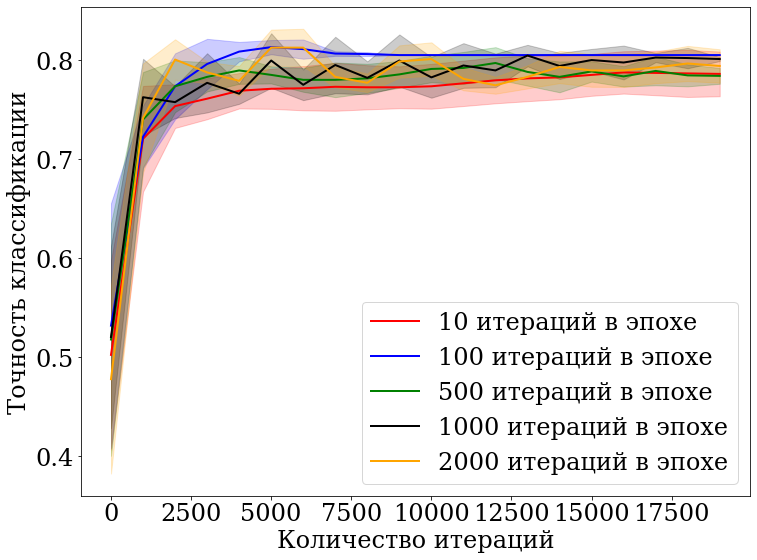

In [112]:
def plot_data(data, label, color):
    e = np.array([data[0][i][0] for i in range(len(data[0]))])
    acc = np.array([subdata[i][1] for i in range(len(data[0])) for subdata in data]).reshape(e.shape[0], -1)
    plt.plot(e, acc.mean(1), '-', color=color, label=label)
    plt.fill_between(e, acc.mean(1)-acc.std(1), acc.mean(1)+acc.std(1), alpha=0.2, color=color)

plot_data(data_10, '10 итераций в эпохе', 'red')
plot_data(data_100, '100 итераций в эпохе', 'blue')
plot_data(data_500, '500 итераций в эпохе', 'green')
plot_data(data_1000, '1000 итераций в эпохе', 'black')
plot_data(data_2000, '2000 итераций в эпохе', 'orange')
plt.legend()
plt.xlabel('Количество итераций')
plt.ylabel('Точность классификации')
# plt.title('График зависимости точности классификации от\n номера итерации при различных значениях размера эпохи')
plt.savefig('linear_epoch_size.pdf')
plt.show()

In [98]:
with open("exp2_linear_exp_splines_train_every_2.jsonl", "r") as read_file:
    data_2 = [json.loads(line) for line in read_file]
with open("exp2_linear_exp_splines_train_every_3.jsonl", "r") as read_file:
    data_3 = [json.loads(line) for line in read_file]
with open("exp2_linear_exp_splines_train_every_5.jsonl", "r") as read_file:
    data_5 = [json.loads(line) for line in read_file]
with open("exp2_linear_exp_splines_train_every_10.jsonl", "r") as read_file:
    data_10 = [json.loads(line) for line in read_file]

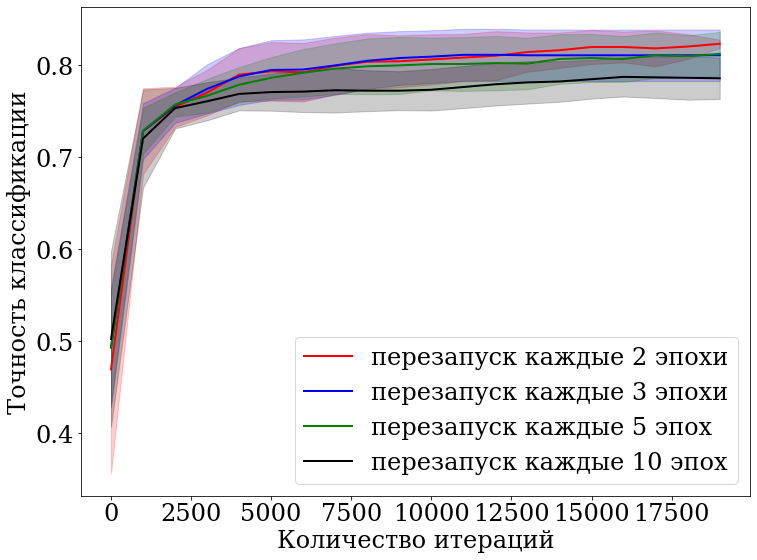

In [111]:
def plot_data(data, label, color):
    e = np.array([data[0][i][0] for i in range(len(data[0]))])
    acc = np.array([subdata[i][1] for i in range(len(data[0])) for subdata in data]).reshape(e.shape[0], -1)
    plt.plot(e, acc.mean(1), '-', color=color, label=label)
    plt.fill_between(e, acc.mean(1)-acc.std(1), acc.mean(1)+acc.std(1), alpha=0.2, color=color)

plot_data(data_2, 'перезапуск каждые 2 эпохи', 'red')
plot_data(data_3, 'перезапуск каждые 3 эпохи', 'blue')
plot_data(data_5, 'перезапуск каждые 5 эпох', 'green')
plot_data(data_10, 'перезапуск каждые 10 эпох', 'black')
plt.legend()
plt.xlabel('Количество итераций')
plt.ylabel('Точность классификации')
# plt.title('График зависимости точности классификации от\n номера итерации при различных train_splines_every_epoch')
plt.savefig('linear_train_splines_every_epoch.pdf')
plt.show()

In [96]:
with open("exp2_linear_exp_splines_train_every_2.jsonl", "r") as read_file:
    data_spline = [json.loads(line) for line in read_file]
with open("exp1_linear_exp_hyper_opt.jsonl", "r") as read_file:
    data_opt = [json.loads(line) for line in read_file]
with open("exp2_linear_exp_random.jsonl", "r") as read_file:
    data_rand = [json.loads(line) for line in read_file]

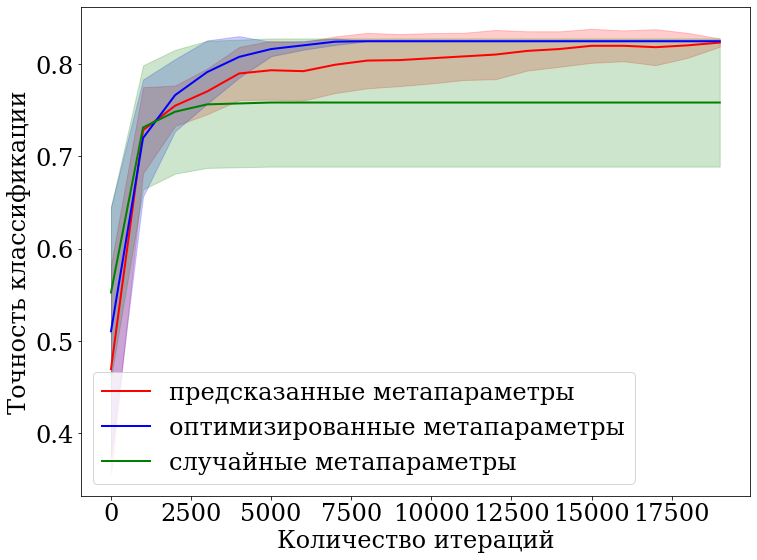

In [97]:
def plot_data(data, label, color):
    e = np.array([data[0][i][0] for i in range(len(data[0]))])
    acc = np.array([subdata[i][1] for i in range(len(data[0])) for subdata in data]).reshape(e.shape[0], -1)
    plt.plot(e, acc.mean(1), '-', color=color, label=label)
    plt.fill_between(e, acc.mean(1)-acc.std(1), acc.mean(1)+acc.std(1), alpha=0.2, color=color)

plot_data(data_spline, 'предсказанные метапараметры', 'red')
plot_data(data_opt, 'оптимизированные метапараметры', 'blue')
plot_data(data_rand, 'случайные метапараметры', 'green')
plt.legend()
plt.xlabel('Количество итераций')
plt.ylabel('Точность классификации')
# plt.title('График зависимости точности классификации от\n номера итерации')
plt.savefig('acc_iter.pdf')
plt.show()

In [100]:
with open("exp2_linear_exp_splines_train_every_2.jsonl", "r") as read_file:
    data_spline2 = [json.loads(line) for line in read_file]
with open("exp2_linear_exp_splines_train_every_3.jsonl", "r") as read_file:
    data_spline3 = [json.loads(line) for line in read_file]
with open("exp2_linear_exp_splines_train_every_5.jsonl", "r") as read_file:
    data_spline5 = [json.loads(line) for line in read_file]
with open("exp2_linear_exp_splines_train_every_10.jsonl", "r") as read_file:
    data_spline10 = [json.loads(line) for line in read_file]

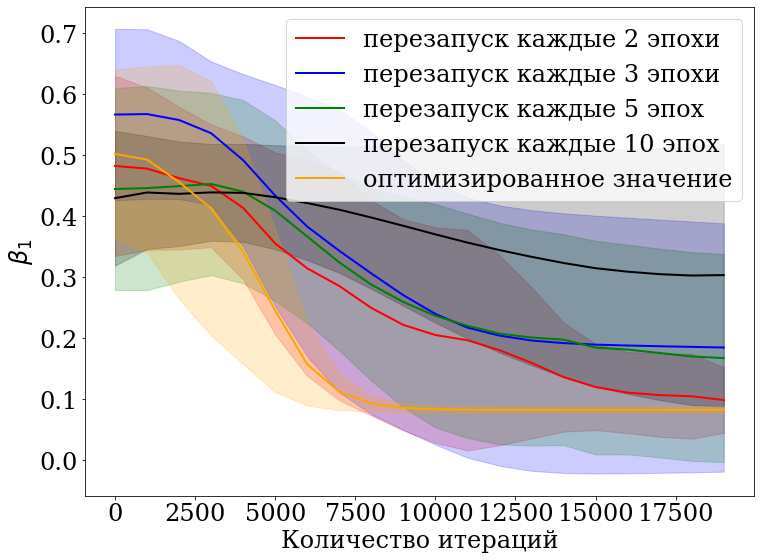

In [108]:
def plot_data_params(data, j, label, color):
    e = np.array([data[0][i][0] for i in range(len(data[0]))])
    par = np.array([subdata[i][j] for i in range(len(data[0])) for subdata in data]).reshape(e.shape[0], -1)
    plt.plot(e, par.mean(1), '-', color=color, label=label)
    plt.fill_between(e, par.mean(1)-par.std(1), par.mean(1)+par.std(1), alpha=0.2, color=color)

plot_data_params(data_spline2, 2, 'перезапуск каждые 2 эпохи', 'red')
plot_data_params(data_spline3, 2, 'перезапуск каждые 3 эпохи', 'blue')
plot_data_params(data_spline5, 2, 'перезапуск каждые 5 эпох', 'green')
plot_data_params(data_spline10, 2, 'перезапуск каждые 10 эпох', 'black')
plot_data_params(data_opt, 2, 'оптимизированное значение', 'orange')
plt.xlabel('Количество итераций')
plt.ylabel(r'$\beta_1$')
# plt.title(r'График зависимости значения $\beta_1$ от номера итерации')
plt.legend()
plt.savefig('beta1_iter.pdf')
plt.show()

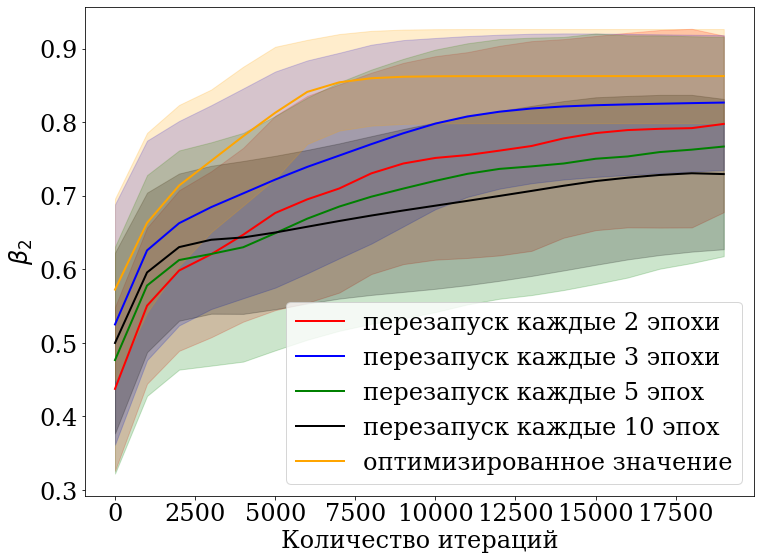

In [109]:
plot_data_params(data_spline2, 3, 'перезапуск каждые 2 эпохи', 'red')
plot_data_params(data_spline3, 3, 'перезапуск каждые 3 эпохи', 'blue')
plot_data_params(data_spline5, 3, 'перезапуск каждые 5 эпох', 'green')
plot_data_params(data_spline10, 3,'перезапуск каждые 10 эпох', 'black')
plot_data_params(data_opt, 3, 'оптимизированное значение', 'orange')
plt.xlabel('Количество итераций')
plt.ylabel(r'$\beta_2$')
# plt.title(r'График зависимости значения $\beta_2$ от номера итерации')
plt.legend()
plt.savefig('beta2_iter.pdf')
plt.show()

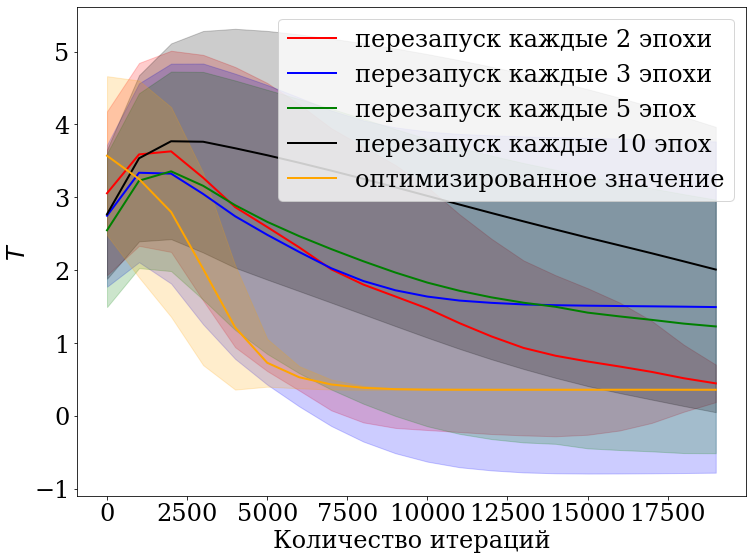

In [110]:
plot_data_params(data_spline2, 4, 'перезапуск каждые 2 эпохи', 'red')
plot_data_params(data_spline3, 4, 'перезапуск каждые 3 эпохи', 'blue')
plot_data_params(data_spline5, 4, 'перезапуск каждые 5 эпох', 'green')
plot_data_params(data_spline10, 4, 'перезапуск каждые 10 эпох', 'black')
plot_data_params(data_opt, 4, 'оптимизированное значение', 'orange')
plt.xlabel('Количество итераций')
plt.ylabel(r'$T$')
# plt.title(r'График зависимости значения $T$ от номера итерации')
plt.legend()
plt.savefig('temp_iter.pdf')
plt.show()